In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

## Loading Data

In [2]:
data = pd.read_csv(
    'drive/MyDrive/Churn_Modelling.xls',
    dtype={
        'Gender': 'category',
        'Geography': 'category'
    }
)
data.set_index(['RowNumber'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RowNumber        10000 non-null  int64   
 1   CustomerId       10000 non-null  int64   
 2   Surname          10000 non-null  object  
 3   CreditScore      10000 non-null  int64   
 4   Geography        10000 non-null  category
 5   Gender           10000 non-null  category
 6   Age              10000 non-null  int64   
 7   Tenure           10000 non-null  int64   
 8   Balance          10000 non-null  float64 
 9   NumOfProducts    10000 non-null  int64   
 10  HasCrCard        10000 non-null  int64   
 11  IsActiveMember   10000 non-null  int64   
 12  EstimatedSalary  10000 non-null  float64 
 13  Exited           10000 non-null  int64   
dtypes: category(2), float64(2), int64(9), object(1)
memory usage: 957.3+ KB


In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Visualization

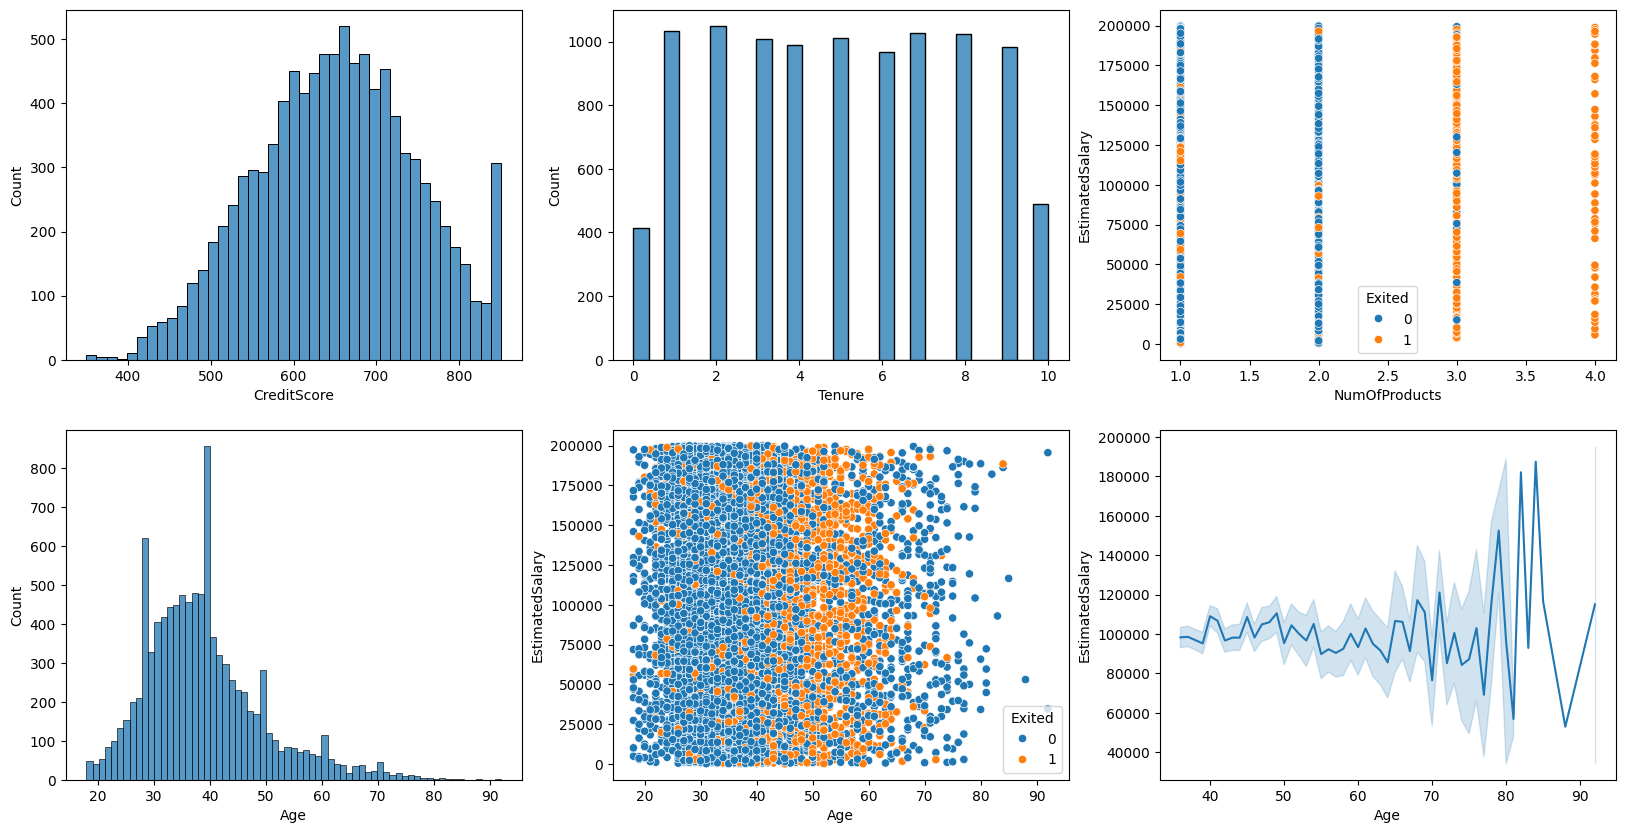

In [4]:
plt.figure(figsize=(20, 10), )

plt.subplot(231)
sns.histplot(x='CreditScore', data=data)

plt.subplot(232)
sns.histplot(x='Tenure', data=data)


plt.subplot(233)
sns.scatterplot(x='NumOfProducts', y='EstimatedSalary', hue='Exited', data=data)


plt.subplot(234)
sns.histplot(x='Age', data=data)

plt.subplot(235)
sns.scatterplot(y='EstimatedSalary', x='Age', hue='Exited', data=data)

plt.subplot(236)
sns.lineplot(x='Age', y='EstimatedSalary', data=data[data['Age'] > 35 ])

plt.show()

In [5]:
def preprocess(data_frame: pd.DataFrame) -> pd.DataFrame:
  processed_df = data_frame.copy().drop(
      ['CustomerId', 'Surname'], axis=1
  )
  processed_df['Gender'] = processed_df['Gender'].cat.codes
  processed_df['Geography'] = processed_df['Geography'].cat.codes

  return processed_df

In [6]:
processed_df = preprocess(data)
processed_df.describe()

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,650.528800,0.746300,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,96.653299,0.827529,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,652.000000,0.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,718.000000,1.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,850.000000,2.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Training and Evaluation

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score


train_x, test_x, train_y, test_y = train_test_split(
    processed_df.drop('Exited', axis=1),
    processed_df['Exited'],
    train_size = .75
)


In [8]:
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from lightgbm import LGBMClassifier


dt = DecisionTreeClassifier()
xgbrf = XGBRFClassifier()
xgb = XGBClassifier()
rf = RandomForestClassifier()
vt = VotingClassifier(
    estimators=[
        ('dt', dt),
        ('xgbrf', xgbrf),
        ('xgb', xgb),
        ('rf', rf),
    ]
)
bg = BaggingClassifier(
    estimator=rf,
    n_estimators=10
)


clfs = [
    (dt, dt.__class__.__name__),
    (xgbrf, xgbrf.__class__.__name__),
    (xgb, xgb.__class__.__name__),
    (rf, rf.__class__.__name__),
    (vt, vt.__class__.__name__),
    (bg, bg.__class__.__name__)
]


In [9]:
def train_model(clfs, tx, ty, vx, vy):
  for clf, name in clfs:
    print("================")
    print('Training: ', name)
    clf.fit(tx, ty)
    y_p = clf.predict(vx)
    print(roc_auc_score(vy, y_p))

In [10]:
train_model(
    clfs,
    train_x, train_y, test_x, test_y
)

Training:  DecisionTreeClassifier
0.6902894436326829
Training:  XGBRFClassifier
0.7052157312187031
Training:  XGBClassifier
0.7185763315035232
Training:  RandomForestClassifier
0.7090282647489184
Training:  VotingClassifier
0.6987341667876587
Training:  BaggingClassifier
0.7005655215164874


In [17]:
xgb_params = {
    'n_estimators': np.linspace(10, 200, 5).astype(np.int32),
    'max_depth': np.linspace(1, 20, 5).astype(np.int32)
}

bg_params = {
    'n_estimators': np.linspace(10, 50, 5).astype(np.int32),
    'max_samples': np.linspace(0.1, 1, 5)
}

bg = BaggingClassifier(estimator=xgb)

models = [
    (GridSearchCV(xgb, xgb_params), xgb.__class__.__name__),
    (GridSearchCV(bg, bg_params), bg.__class__.__name__)
]


In [18]:
train_model(
    models,
    train_x, train_y, test_x, test_y
)

Training:  XGBClassifier
0.7096733835218233
Training:  BaggingClassifier
0.7181850383930621
